In [1]:
#tool box
import pandas as pd
from scipy import stats
import numpy as np
from matplotlib import pyplot as plt

#stylin
plt.style.use('seaborn-darkgrid')

#import the data
pd.read_excel('river_13C_data(4)_ph.xlsx')
data1=pd.read_excel('river_13C_data(4)_ph.xlsx')

/opt/anaconda3/lib/python3.7/site-packages/openpyxl/worksheet/_reader.py:296: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [2]:
subset=pd.DataFrame({'geo_class':['river','river plume','river mouth','tributary','catchment','watershed','reservoir']})
data=subset.merge(data1,on='geo_class')

In [3]:
#convert all units to µM/L
tmp_data=[]
for i,d in data.iterrows():
    #uM/L --> mM/L
    if d['DIC_units']=='µM/L':
        tmp_data.append(d['DIC'])
    #mM/L --> mM/L
    elif d['DIC_units']=='mM/L':
        tmp_data.append(d['DIC']*1000)
    #mM/Kg --> mM/L
    elif d['DIC_units']=='mM/kg':
        tmp_data.append(d['DIC']*1000)
    #uM/kg --> mM/L
    elif d['DIC_units']=='µM/kg':
        tmp_data.append(d['DIC']) 
    #mg C/L --> mM/L
    elif d['DIC_units']=='mg C/L':
        tmp_data.append((d['DIC']/12.011)*1000)
    else:
        tmp_data.append(np.nan)
        
tmp_data=np.array(tmp_data)
data['DIC_trans']=tmp_data.astype(float)

In [4]:
Alk_data=[]
for i,d in data.iterrows():
    if d['Alk_units']=='mM/L':
        Alk_data.append(d['Alk']*1000)
    elif d['Alk_units']=='mM/kg':
        Alk_data.append(d['Alk']*1000)
    elif d['Alk_units']=='meq/L':
        Alk_data.append(d['Alk']*1000)
    elif d['Alk_units']=='µM/L':
        Alk_data.append(d['Alk'])
    elif d['Alk_units']=='M/kg':
        Alk_data.append(d['Alk'])
    elif d['Alk_units']=='µeq/L':
        Alk_data.append(d['Alk'])
    else:
        Alk_data.append(np.nan)
        
Alk_data=np.array(Alk_data)
data['Alk_trans']=Alk_data.astype(float)

In [5]:
import numpy as np
import pandas as pd
import xarray
from matplotlib import pyplot as plt

In [6]:
# define input conditions; DIC and Alk
kwargs = dict(
    par1 = data['Alk_trans'],
    par1_type = 1, #alkalinity
    par2 = data['DIC_trans'],
    par2_type = 2 #DIC
)
print("Conditions have been defined!")

Conditions have been defined!


In [7]:
# Import PyCO2SYS
import PyCO2SYS as pyco2

# Run PyCO2SYS
results = pyco2.sys(**kwargs)

# Extract and print out the result
pH = results['pH']
pH_data=np.array(pH)
#save ph_predicted as its own column
data['ph_pred']=pH_data.astype(float)

In [8]:
#calculate d13C_pred

T=25    #degree C
S=35    #PSS
TK = T + 273.15 
DIC=np.array(data['DIC_trans'])

K1 = 10**(-(3633.86/TK - 61.2172 + 9.67770 * np.log(TK)- 0.011555*S + 0.0001152 * S**2))
K2 = 10**(-(471.78/TK + 25.9290 - 3.16967 * np.log(TK) - 0.01781*S + 0.0001122 * S**2))


H=10**(-data['ph_pred'])

#DIC concentrations calculated from pH
HCO_3 = DIC/(1 + H/K1 + K2/H)
CO_3 = DIC/(1 + H/K2 + H*H/(K1*K2))
CO2 = DIC/(1 + K1/H + K1*K2/(H*H))

#set d13C for DIC components
CO2aq=-9
CO3=-2
HCO3=0

#calculate d13C_DIC from DIC component concentrations

d13C_DIC_pred = (CO2/DIC)*CO2aq + (CO_3/DIC)*CO3 + (HCO_3/DIC)*HCO3
data['d13C_DIC_pred']=d13C_DIC_pred.astype(float)

In [9]:
#calculate residual (d13C_measured - d13C_predicted)

r = np.array(data['d13C_DIC']) - np.array(data['d13C_DIC_pred'])
len(r)

2114

373.0

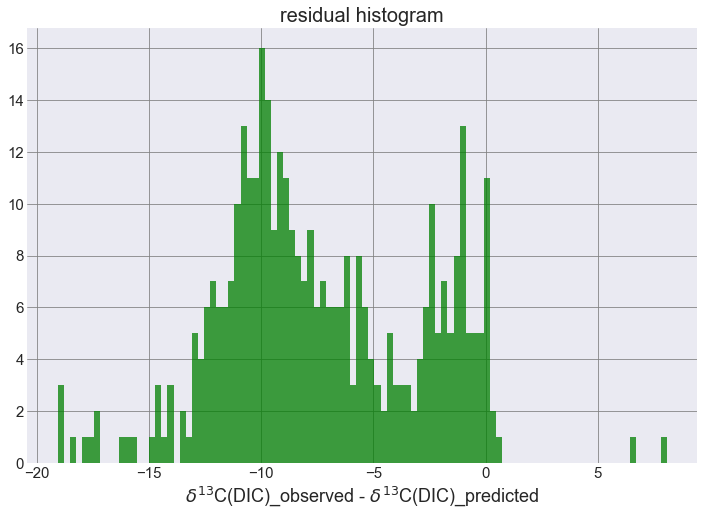

In [11]:
#plot residual histogram

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(12,8))
n,bins,patches = plt.hist(r,100,facecolor='g',alpha=0.75)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.ylabel('',fontsize=18)
plt.xlabel('$\delta^{13}$C(DIC)_observed - $\delta^{13}$C(DIC)_predicted',fontsize=18)
plt.title('residual histogram', fontsize=20)
plt.grid(color='grey')
np.sum(n)

# calculate d13C from pH measured too, then calculate new residual...